sources
- Noise is generated using this algorithm: http://adsabs.harvard.edu/pdf/1995A%26A...300..707T
- https://greenteapress.com/thinkdsp/html/thinkdsp006.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
import colorednoise as cn

In [3]:
beta = 0.5 # the exponent
samples = 2**20 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples)

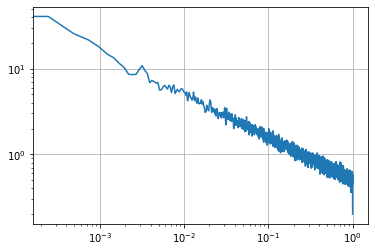

In [4]:
# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
from matplotlib import pylab as plt
s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()

In [5]:
samples

1048576

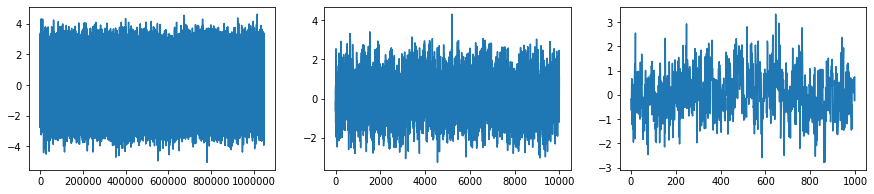

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(15,3))
axs[0].plot(y)
axs[1].plot(y[:10000])
axs[2].plot(y[:1000])

In [7]:
def autocorrelate(y, range_ = range(1,100), parallel=False):
    return [np.corrcoef(y[i:], y[:-i])[0][1] for i in tqdm(range_)]

In [8]:
range_ = np.arange(1,1000)

In [9]:
autocorr = autocorrelate(y, range_)

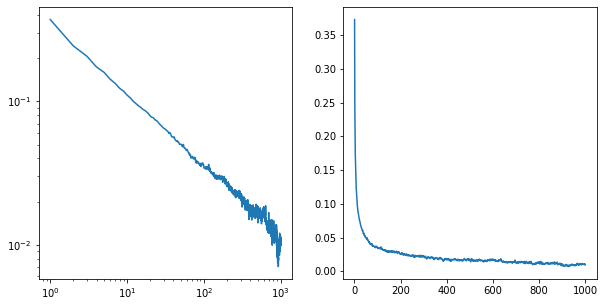

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, autocorr)
ax.set_yscale('log')
ax.set_xscale('log')
ax = axs[1]
ax.plot(range_, autocorr)


In [11]:
nbins = 10
bins =  np.linspace(np.min(y), np.max(y), nbins)
y_dig = np.digitize(y, bins, right=True)

In [12]:
bins

array([-5.04286154, -3.9690271 , -2.89519266, -1.82135822, -0.74752378,
        0.32631065,  1.40014509,  2.47397953,  3.54781397,  4.62164841])

In [21]:
distances = np.unique(np.logspace(0, 3, 100, base=10).astype('int'))
distances = np.arange(1, 1001)

In [22]:
from childes_mi.information_theory import mutual_information as mi

In [23]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    [y_dig], distances=distances, n_jobs=-1
)
MI_DF =  pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "no_markov"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    5.4s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    6.5s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.8s finished


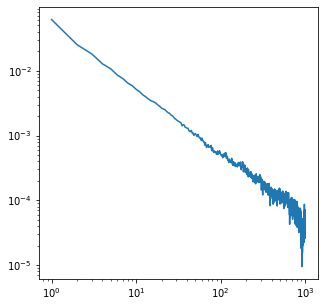

In [24]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI

ax.plot(distances, MI)
ax.set_yscale('log')
ax.set_xscale('log')

In [25]:
from scipy.spatial import distance_matrix

In [26]:
n = 1000
dist = distance_matrix(np.expand_dims(y[:n],1), np.expand_dims(y[:n],1))

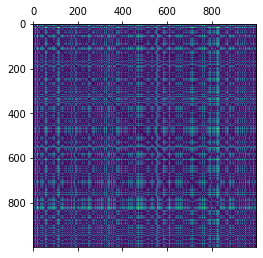

In [27]:
plt.matshow(dist)

In [30]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [50]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

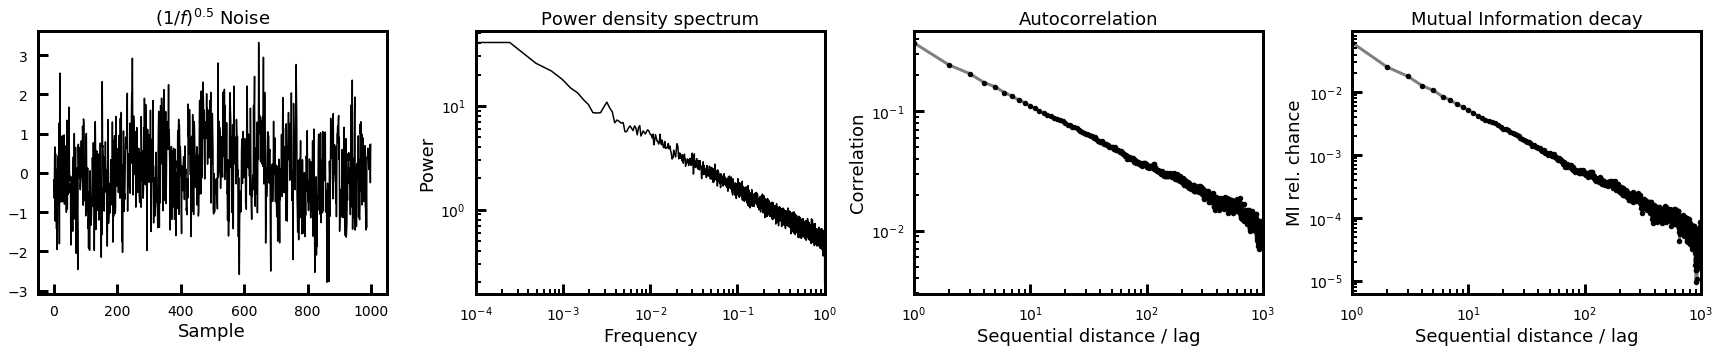

In [60]:
fig, axs = plt.subplots(ncols=4, figsize=(24,5))

# pink noise
ax = axs[0]
ax.plot(y[:1000], color ='k')
ax.set_xlabel('Sample', fontsize=18)
ax.set_title('$(1/f)^{0.5}$ Noise', fontsize=18)

# power spectrum
ax = axs[1]
s, f = mlab.psd(y, NFFT=2**13)
ax.plot(f,s, color ='k')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.grid(True)
ax.set_xlabel('Frequency', fontsize=18)
ax.set_ylabel('Power', fontsize=18)
ax.set_title('Power density spectrum', fontsize=18)
ax.set_xlim([1e-4,1])
# autocorrelation
ax = axs[2]
ax.set_xlabel('Sequential distance / lag', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.set_title('Autocorrelation', fontsize=18)
ax.plot(range_, autocorr, color ='k', alpha = 0.5, lw=3)
ax.scatter(range_, autocorr, color ='k', s=20)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.grid(True)
ax.set_xlim([1,1000])

# mutual information
ax = axs[3]
ax.set_xlabel('Sequential distance / lag', fontsize=18)
ax.set_ylabel('MI rel. chance', fontsize=18)
ax.set_title('Mutual Information decay', fontsize=18)
MI = row.MI-row.shuff_MI
ax.plot(distances, MI, color ='k', alpha = 0.5, lw=3)
ax.scatter(distances, MI, color ='k', s=20)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.grid(True)
ax.set_xlim([1,1000])

for axi, ax in enumerate(axs.flatten()):

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    #ax.grid(False)
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)


plt.tight_layout()
save_fig(FIGURE_DIR/'pink_noise_example')